<a href="https://colab.research.google.com/github/ADIthaker/CNN-Techniques/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import *
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [24]:
class StyleTransferrer(object):
  def __init__(self, content_layers=None, style_layers=None):
    self.style_weight = 1e-2
    self.model = VGG19(weights='imagenet', include_top=False)
    self.model.trainable = False
    self.content_weight = 1e4
    if content_layers is None:
      self.content_layers = ['block5_conv2']
    else:
      self.content_layers = content_layers
    
    if style_layers is None:
      self.style_layers = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']
    else :
      self.style_layers = style_layers
    outputs = [self.model.get_layer(name).output for name in (self.style_layers + self.content_layers)]
    self.style_model = Model([self.model.input], outputs)
  
  def _gram_matrix(self, input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd',input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = np.prod(input_shape[1:3])
    num_locations = tf.cast(num_locations, tf.float32)
    result = result / num_locations
    return result
  
  def _calc_outputs(self, inputs):
    inputs = inputs *255
    preprocessed_input = preprocess_input(inputs)
    outputs = self.style_model(preprocessed_input)
    style_outputs = outputs[:len(self.style_layers)]
    content_outputs = outputs[len(self.style_layers):]
    style_outputs = [self._gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for (content_name, value) in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for (style_name, value) in zip(self.style_layers, style_outputs)}

    return {
        'content': content_dict,
        'style': style_dict
    }

  @staticmethod
  def _clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0,clip_value_max=1.0)
  
  @staticmethod
  def _compute_loss(outputs, targets):
    return tf.add_n([
                     tf.reduce_mean((outputs[key] - targets[key])**2)
                     for key in outputs.keys()
    ])
  def _calc_total_loss(self, outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    n_style_layers = len(self.style_layers)
    s_loss = self._compute_loss(style_outputs, style_targets)
    s_loss *= self.style_weight / n_style_layers
    n_content_layers = len(self.content_layers)
    c_loss = self._compute_loss(content_outputs, content_targets)
    c_loss *= self.content_weight / n_content_layers

    return s_loss + c_loss

  @tf.function()
  def _train(self, image, s_targets, c_targets, epochs, steps_per_epoch):
    optimizer = tf.optimizers.Adam(learning_rate=2e-2,beta_1=0.99,epsilon=0.1)
    for _ in tqdm(range(epochs)):
      for _ in range(steps_per_epoch):
        with tf.GradientTape() as tape:
          outputs = self._calc_outputs(image)
          loss = self._calc_total_loss(outputs, s_targets, c_targets)
        gradient = tape.gradient(loss, image)
        optimizer.apply_gradients([(gradient, image)])
        image.assign(self._clip_0_1(image))
    return image
  
  @staticmethod
  def _tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
      tensor = tensor[0]
    return tensor

  def transfer(self, s_image, c_image, epochs=10, steps_per_epoch=100):
    s_targets = self._calc_outputs(s_image)['style']
    c_targets = self._calc_outputs(c_image)['content']
    image = tf.Variable(c_image)
    image = self._train(image, s_targets, c_targets, epochs, steps_per_epoch)
    return self._tensor_to_image(image)


In [25]:
tf.config.run_functions_eagerly(True)

In [26]:
def load_image(image_path):
    dimension = 512
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    longest_dimension = max(shape)
    scale = dimension / longest_dimension

    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    return image[tf.newaxis, :]


def show_image(image):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    plt.show()

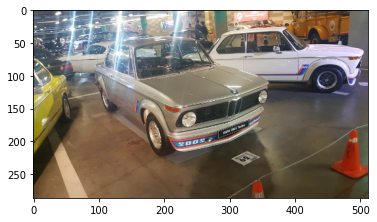

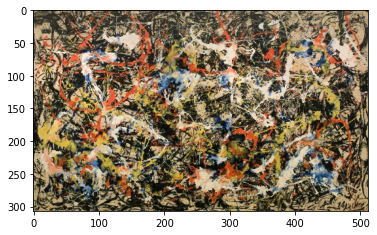

In [27]:
content = load_image('bmw.jpg')
show_image(content)
style = load_image('pollock.jpg')
show_image(style)

100%|██████████| 10/10 [04:10<00:00, 25.10s/it]


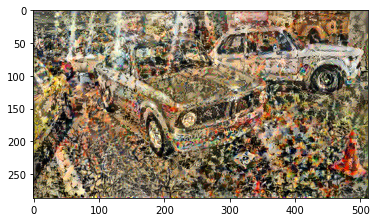

In [28]:
stylized_image = StyleTransferrer().transfer(style, content)
show_image(stylized_image)

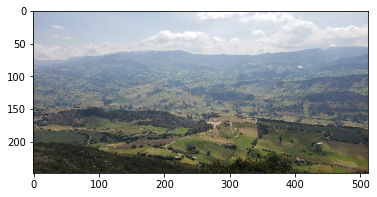

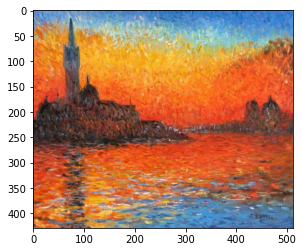

100%|██████████| 10/10 [03:53<00:00, 23.36s/it]


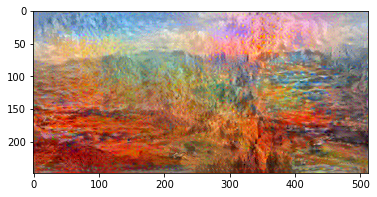

In [30]:
content = load_image('landscape.jpg')
show_image(content)
style = load_image('monet.jpg')
show_image(style)
stylized_image = StyleTransferrer().transfer(style, content)
show_image(stylized_image)

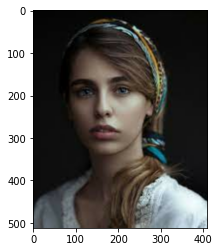

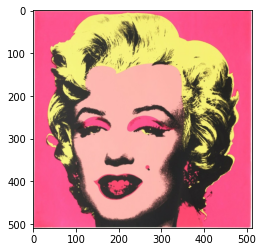

100%|██████████| 10/10 [05:37<00:00, 33.72s/it]


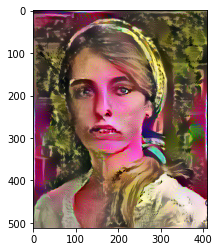

In [32]:
content = load_image('girl.jpg')
show_image(content)
style = load_image('warhol.jpg')
show_image(style)
stylized_image = StyleTransferrer().transfer(style, content)
show_image(stylized_image)

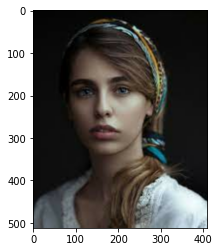

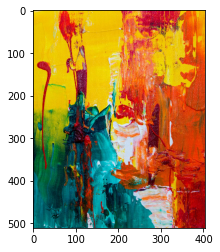

100%|██████████| 10/10 [05:36<00:00, 33.60s/it]


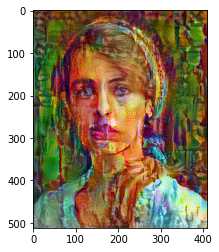

In [33]:
content = load_image('girl.jpg')
show_image(content)
style = load_image('art.jpg')
show_image(style)
stylized_image = StyleTransferrer().transfer(style, content)
show_image(stylized_image)